In [1]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import pandas as pd
from pycbc.filter import sigma
import h5py

In [2]:
%matplotlib inline

In [3]:
def gen_noise(psd_need):
    
    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    if (psd_need == True) :
        pp.plot(psd.sample_frequencies,psd.data)
        pp.loglog()
        pp.xlim(30,2000)
        pp.ylabel('$Strain^2 / Hz$')
        pp.xlabel('Frequency (Hz)')
        pp.show()


    # Generate 256 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(256/ delta_t)
    ts = pycbc.noise.gaussian.noise_from_psd(tsamples,delta_t, psd, seed=127)
    
    
    #plotting noise 
#     pp.plot(ts.sample_times, ts)
#     pp.ylabel('Strain')
#     pp.xlabel('Time (simport numpy as np

#     pp.show()
    

    return ts



In [4]:
def gen_waveform(model,m1,m2,s1z,s2z,distance,time,l):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    hp_1, hc_1 = get_td_waveform(approximant=model,
                             mass1=m1, mass2=m2,spin1z=s1z,spin2z=s2z,
                             distance=distance, inclination=inclination_1,
                             delta_t=1.0/4096, f_lower=30)

    ht_1 = fp * hp_1 + fc * hc_1

    return ht_1

In [5]:
def overlap(ht_1,ht_2,buffer):

    if len(ht_1) < len(ht_2):
        ht_small, ht_big = ht_1, ht_2
    else:
        ht_small, ht_big = ht_2, ht_1

    dt = ht_small.delta_t

    # make buffer int multiple of dt
    buffer = np.round(buffer*ht_big.sample_rate)/ht_big.sample_rate
    # elongate the long template to accomodate enough space on left
    ht_big.resize(len(ht_big)+int(buffer*ht_big.sample_rate))
    # match small template
    ht_small.resize(len(ht_big))
    # correct the position after resizing
    ht_big = ht_big.cyclic_time_shift(buffer)
    #Shifting the merger time
    ht_small = ht_small.cyclic_time_shift(ht_small.start_time-ht_big.start_time-buffer)
    #Equating the start time of both signals
    ht_small.start_time = ht_big.start_time
    # resample to original sample rate
    ht_big = ht_big.resample(dt)
    ht_small = ht_small.resample(dt)

    #Combining the signals
    ht_total = ht_small + ht_big

    return ht_total,ht_2

In [6]:
def overlap(ht_1,ht_2,buffer):

    if len(ht_1) < len(ht_2):
        ht_small, ht_big = ht_1, ht_2
    else:
        ht_small, ht_big = ht_2, ht_1

    dt = ht_small.delta_t

    # make buffer int multiple of dt
    buffer = np.round(buffer*ht_big.sample_rate)/ht_big.sample_rate
    # elongate the long template to accomodate enough space on left
    ht_big.resize(len(ht_big)+int(buffer*ht_big.sample_rate))
    # match small template
    ht_small.resize(len(ht_big))
    # correct the position after resizing
    ht_big = ht_big.cyclic_time_shift(buffer)
    #Shifting the merger time
    ht_small = ht_small.cyclic_time_shift(ht_small.start_time-ht_big.start_time-buffer)
    #Equating the start time of both signals
    ht_small.start_time = ht_big.start_time
    # resample to original sample rate
    ht_big = ht_big.resample(dt)
    ht_small = ht_small.resample(dt)

    #Combining the signals
    ht_total = ht_small + ht_big

    return ht_total,ht_2

In [7]:
def inject(ht_total,ts,injtime):

    # append extra zeros than required
    ht_total.append_zeros(int((ts.duration-injtime)*1.2*4096))

    ht_total = ht_total.cyclic_time_shift(int(injtime + ht_total.start_time))
    ht_total = ht_total.resample(ts.delta_t)

    #Resizing the signal
    ht_total.resize(len(ts))

    #Equating the start time
    ht_total.start_time = ts.start_time

    #Injecting signal into noise
    ts = ts.add_into(ht_total)

    #plotting the result
    # pp.plot(ts.sample_times, ts)
    # pp.xlabel('Time(s)')
    # pp.ylabel('Strain')
    # pp.grid()
    # pp.show()

    return ts

In [8]:
def psd_data(conditioned):

    from pycbc.psd import interpolate, inverse_spectrum_truncation
    # Estimate the power spectral density

    # We use 4 second samples of our time series in Welch method.
    psd = conditioned.psd(4)

    # Now that we have the psd we need to interpolate it to match our data
    # and then limit the filter length of 1 / PSD. After this, we can
    # directly use this PSD to filter the data in a controlled manner

    psd = interpolate(psd, conditioned.delta_f)

    # 1/PSD will now act as a filter with an effective length of 4 seconds
    # Since the data has been highpassed above 30 Hz, and will have low values
    # below this we need to informat the function to not include frequencies
    # below this frequency. 
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=30)

#     pp.loglog(psd.sample_frequencies, psd)
#     pp.ylabel('$Strain^2 / Hz$')
#     pp.xlabel('Frequency (Hz)')
#     pp.xlim(30, 1024)
    
    return psd

In [9]:
def template_bank(m_1,m_2,m_radius,temp_numb):

    # Generate templates for BNS
    temp_bank = np.zeros((temp_numb, 2))
    for i in range(temp_numb):
        r1 = np.random.uniform(0,m_radius)
        r2 = np.random.uniform(0,(np.pi*2))           
        m1 = r1*(np.cos(r2)) + m_1
        m2 = r1*(np.sin(r2)) + m_2

        temp_bank[i, :] = [m1, m2]

    temp_bank[i,:] = [m_1,m_2]
    
    return temp_bank


In [10]:
def gen_template(model,m1,m2,s1z,s2z,conditioned):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    
    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    time=0.0



    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    
    
    
    
    hp, hc = get_td_waveform(approximant=model,
                     mass1=m1,
                     mass2=m2,spin1z=s1z,spin2z=s2z,
                     delta_t=conditioned.delta_t,
                     f_lower=30)
    
    
    ht_template = fp * hp + fc * hc
    
    #Resizing the template to match data
    ht_template.resize(len(conditioned))
    
    #Time shift 
    template = ht_template.cyclic_time_shift(ht_template.start_time)
    
    
    
   
    return template


In [11]:
def gen_SNR(template,conditioned,psd):
    from pycbc.filter import matched_filter
    import numpy

    snr = matched_filter(template, conditioned,
                         psd=psd, low_frequency_cutoff=30)



    # The `matched_filter` function actually returns a 'complex' SNR.
    # What that means is that the real portion correponds to the SNR
    # associated with directly filtering the template with the data.
    # The imaginary portion corresponds to filtering with a template that
    # is 90 degrees out of phase. Since the phase of a signal may be 
    # anything, we choose to maximize over the phase of the signal.

   
    peak = abs(snr).numpy().argmax()
    snrpc= snr[peak]
    snrp = abs(snr[peak])
    time = snr.sample_times[peak]
   
    
    return snr,time,peak,snrpc,snrp

In [12]:
def gen_chisquare(temp,data,m_1,m_2,s_1,s_2,psd):
    
    n =int(0.72*pycbc.pnutils.get_freq('fSEOBNRv4Peak',m_1,m_2,s_1,s_2)**0.7)
    
    chisq = power_chisq(temp, data, n, psd=psd, low_frequency_cutoff=30.0)

    # convert to a reduced chisq
    chisq /= (n * 2) - 2
    
    
    
    return chisq


In [13]:
def snr_chisq_nsnr(num_templates,temp_bank,psd,data,model,s):

    template_info = []


    for i in range(num_templates):
        T1 = gen_template(model,temp_bank[i][0],temp_bank[i][1],s,s,data)

        S1,time_bns,index_peak_bns,C_snrp,old_snr_bns = gen_SNR(T1,data,psd)

        chisq_1 = gen_chisquare(T1,data,temp_bank[i,:][0],temp_bank[i,:][1],s,s,psd)
        chisq_val_bns = chisq_1[index_peak_bns]

        new_snr_bns = newsnr(abs(S1),chisq_1)

        snrp_bns = new_snr_bns[index_peak_bns]

        template_info.append([temp_bank[i,:][0],temp_bank[i,:][1],time_bns,old_snr_bns,snrp_bns,chisq_val_bns,C_snrp])

    return template_info
    

In [14]:
def recovery(data,n,bns_bank,bbh_bank,psd): 
    
  

    bns_info =  snr_chisq_nsnr(n,bns_bank,psd,data,'TaylorF2',0.5)

    bbh_info =  snr_chisq_nsnr(n,bbh_bank,psd,data,'IMRPhenomPv2',0.8)

    total_info = [*bbh_info,*bns_info]
    
    

    info = {}
    for i in total_info:
        info.update({i[4] : [i[0],i[1],i[2],i[3],i[5],i[6]]})


    snrp_1 = max(info.keys())
    time_1 = info.get(max(info.keys()))[2]
    m1_1 = info.get(max(info.keys()))[0]
    m2_1 = info.get(max(info.keys()))[1]
    chi_sq_1 = info.get(max(info.keys()))[4]
    Comp_snrp = info.get(max(info.keys()))[5]

    print("The signal detected is due to the following masses ",m1_1,"M and ", m2_1, "M at time ", time_1, "seconds", " with new SNR value as", snrp_1, " and chi~square value as ", chi_sq_1 )
    
    
    return m1_1,m2_1,time_1,snrp_1,total_info,Comp_snrp



In [15]:
def align_sub(m1_1,m2_1,time_1,com_snrp,data,psd):   
    
    # The time, amplitude, and phase of the SNR peak tell us how to align
    # our proposed signal with the data.

    # Shift the template to the peak time
    dt = time_1 - data.start_time 
    
    
#     if (m1_1 >= 15 and m2_1 >= 15) : 
    temp_sub  = gen_template('IMRPhenomPv2',m1_1,m2_1,0.8,0.8,data)
        
#     else :
#         temp_sub = gen_template('TaylorF2',m1_1,m2_1,0.05,0.05,data)
        
     
    
    
    aligned = temp_sub.cyclic_time_shift(dt)

    # scale the template so that it would have SNR 1 in this data
    aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=30.0)

    # Scale the template amplitude and phase to the peak value
    aligned = (aligned.to_frequencyseries() * com_snrp).to_timeseries()
    aligned.start_time = data.start_time

    
    subtracted = data - aligned
    
    psd2 = psd_data(subtracted)  

    
    return subtracted,psd2

In [16]:
noise = gen_noise(False)

bbh_templates = template_bank(20,30,10,20)

bns_templates = template_bank(1.3,1.4,0.25,20)

bank_total = np.concatenate([bbh_templates,bns_templates])


In [17]:
tab = []

for i in range(1):
    
    print("Injection number:",i)
    print(' ')

    i1 = int(np.random.randint(low = 0,high = 20,size = 1))
    i2 = int(np.random.randint(low = 0,high = 20,size = 1))
    m1_1 = bbh_templates[i1][0]
    m2_1 = bbh_templates[i1][1]
    m1_2 = bns_templates[i2][0]
    m2_2 = bns_templates[i2][1]

    buffer = np.random.uniform(0.1,1.8)


    h1_bbh = gen_waveform('IMRPhenomPv2',m1_1,m2_1,0.8,0.8,500,0.0,"BBH")

    h1_bns = gen_waveform('TaylorF2',m1_2,m2_2,0.5,0.5,200,0.0,"BNS")

    ht_total,h1_bbh = overlap(h1_bbh,h1_bns,buffer)

    ts1 = inject(ht_total,noise,101)
    ts1.save(f"Signals_BBH_BNS/Data_{i}.hdf")

    print(m1_1,',',m2_1)
    print(m1_2,',',m2_2)
    print(buffer)
    print(' ')
    print('-------------------------------------------------------------------')
    
    tab.append([m1_1,m2_1,m1_2,m2_2,buffer])

Injection number: 0
 
18.663620006336373 , 28.896306421134952
1.5439411522014528 , 1.3870485180852397
0.6468885164170947
 
-------------------------------------------------------------------


In [18]:
df = pd.DataFrame(tab)
df.to_excel('Signals_BBH_BNS/Injection.xlsx',index = False)

In [19]:
print(len(bank_total))

40


In [21]:
for i in range(20):
    T1 = gen_template('IMRPhenomPv2',bbh_templates[i][0],bbh_templates[i][1],0.8,0.8,ts1)
    T1.save(f"Signals_BBH_BNS/signal_bbh{i}.hdf")
    T2 = gen_template('TaylorF2',bns_templates[i][0],bns_templates[i][1],0.5,0.5,ts1)
    T2.save(f"Signals_BBH_BNS/signal_bns{i}.hdf")

In [22]:
temp_bank = pd.DataFrame(bank_total)

In [23]:
temp_bank.to_csv('Signals_BBH_BNS/Load_bbh_bns.csv',index = False)

<AxesSubplot:xlabel='0', ylabel='1'>

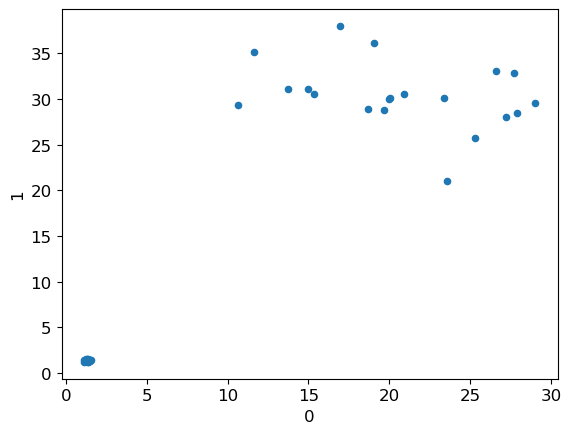

In [24]:
temp_bank.plot(0,1,kind='scatter')